# Data Analytics Project - Models

# Pair 4 - TATAMTRDVR Linear Regression Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 4 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair4/Pair4_orders.csv')
orders_df.head()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
0,2019-05-17,84.500000,83.199997,1.300003,-1.764996,LONG
1,2019-05-20,87.550003,88.849998,-1.299995,-2.747445,LONG
2,2019-05-21,88.250000,83.150002,5.099998,-0.329109,FLAT
3,2019-05-22,87.849998,85.400002,2.449997,-1.330453,FLAT
4,2019-05-23,88.849998,84.849998,4.000000,-0.744760,FLAT


In [3]:
orders_df.tail()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
57,2019-08-07,61.150002,55.650002,5.500000,-0.177963,FLAT
58,2019-08-08,63.549999,58.750000,4.799999,-0.442469,FLAT
59,2019-08-09,64.300003,58.200001,6.100002,0.048757,FLAT
60,2019-08-13,61.549999,57.700001,3.849998,-0.801441,FLAT
61,2019-08-14,62.549999,57.349998,5.200001,-0.291322,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

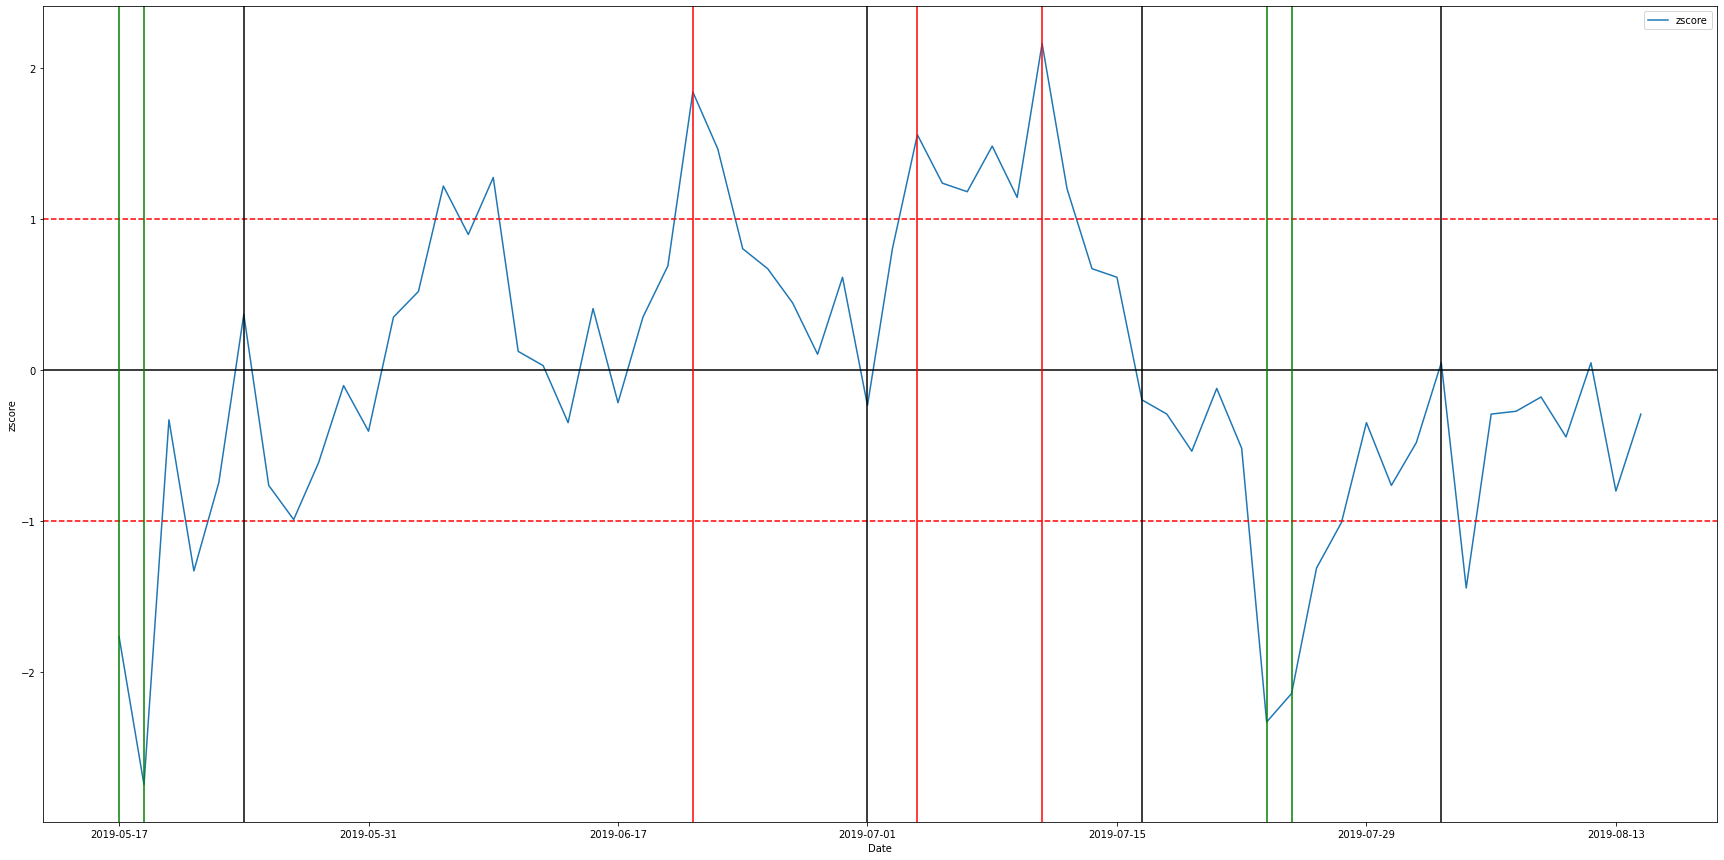

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

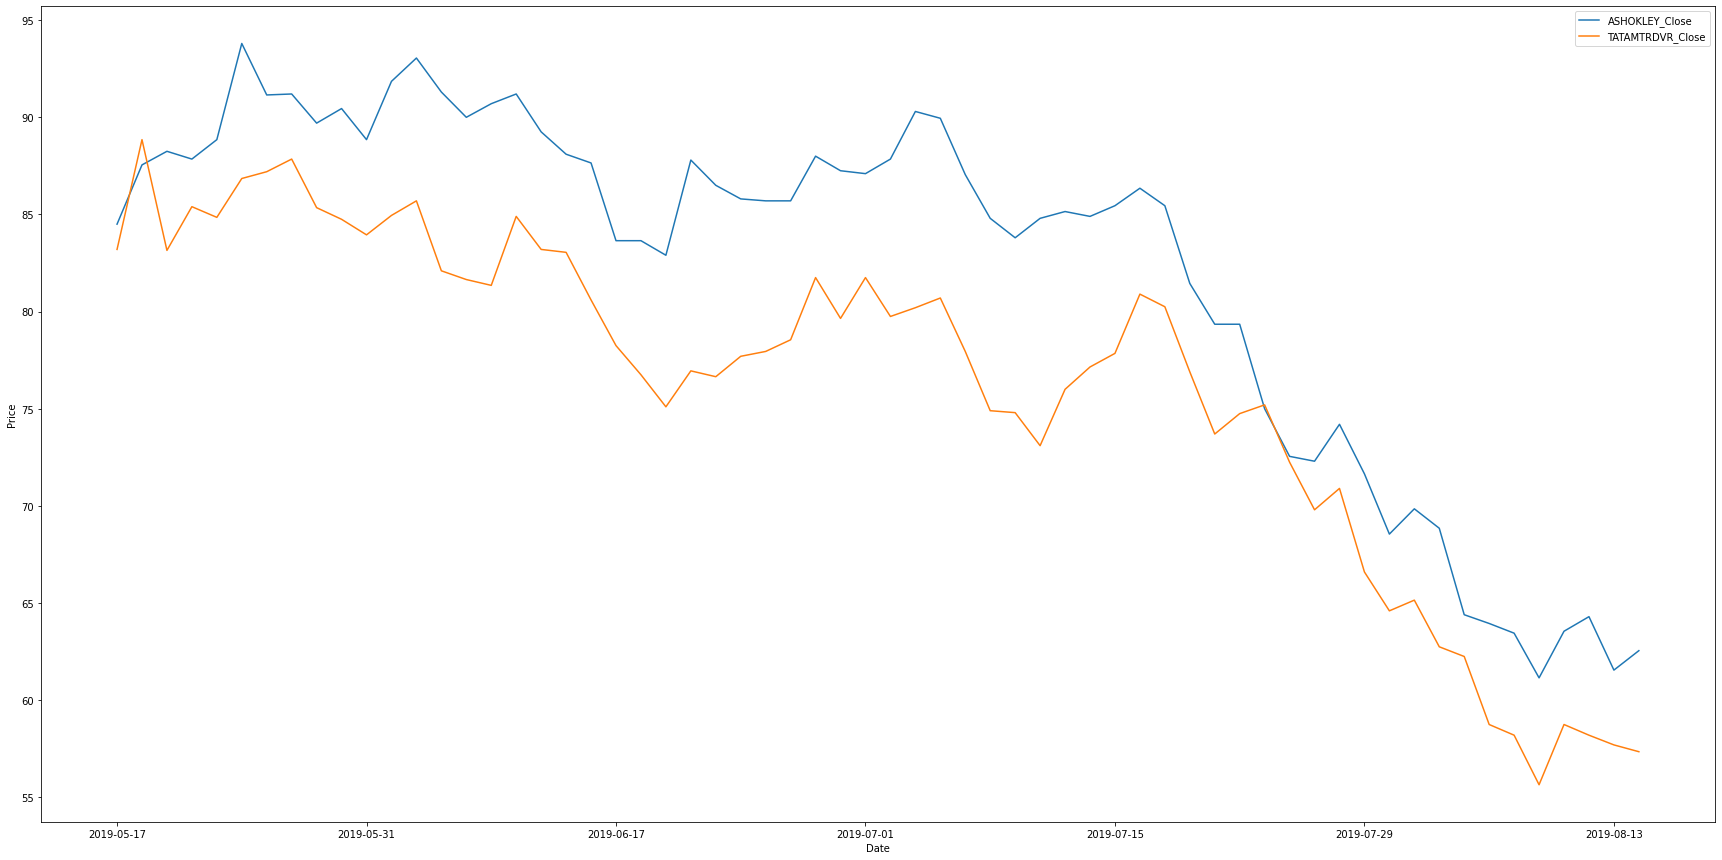

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['ASHOKLEY_Close', 'TATAMTRDVR_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. TATAMTRDVR Linear Regression Model

## 3.1. Get the Complete TATAMTRDVR dataset

In [6]:
tata_df = pd.read_csv("../../Storage/Companies_with_names_exchange/TATAMTRDVRNSE.csv")
tata_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,309.350006,297.250000,301.000000,308.549988,894288.0,308.549988,TATAMTRDVR,NSE
1,2017-01-03,315.100006,306.600006,309.500000,308.399994,1558343.0,308.399994,TATAMTRDVR,NSE
2,2017-01-04,313.950012,308.549988,308.549988,310.250000,850924.0,310.250000,TATAMTRDVR,NSE
3,2017-01-05,324.000000,315.850006,317.000000,322.950012,1886492.0,322.950012,TATAMTRDVR,NSE
4,2017-01-06,325.299988,317.500000,323.000000,318.700012,700519.0,318.700012,TATAMTRDVR,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get TATAMTRDVR training data

### 3.2.1 Get complete tata dataset

In [7]:
tata_df = tata_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
tata_df.head()

,Date,Close
0,2017-01-02,308.549988
1,2017-01-03,308.399994
2,2017-01-04,310.250000
3,2017-01-05,322.950012
4,2017-01-06,318.700012


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
tata_df_train = tata_df[tata_df['Date'] >= '2017-09-03']
tata_df_train.head()

,Date,Close
166,2017-09-04,219.800003
167,2017-09-05,218.899994
168,2017-09-06,214.899994
169,2017-09-07,211.699997
170,2017-09-08,210.149994


In [9]:
tata_df_train = tata_df_train[tata_df_train['Date'] <= '2018-09-04']
tata_df_train.tail()

,Date,Close
412,2018-08-29,140.550003
413,2018-08-30,138.199997
414,2018-08-31,142.050003
415,2018-09-03,144.149994
416,2018-09-04,142.850006


### 3.2.3 Add extra date columns to the training data

In [10]:
add_datepart(tata_df_train, 'Date')

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
166,219.800003,2017,36,9,4,0,247,False,False,False,False,False,False,1504483200
167,218.899994,2017,36,9,5,1,248,False,False,False,False,False,False,1504569600
168,214.899994,2017,36,9,6,2,249,False,False,False,False,False,False,1504656000
169,211.699997,2017,36,9,7,3,250,False,False,False,False,False,False,1504742400
170,210.149994,2017,36,9,8,4,251,False,False,False,False,False,False,1504828800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,140.550003,2018,35,8,29,2,241,False,False,False,False,False,False,1535500800
413,138.199997,2018,35,8,30,3,242,False,False,False,False,False,False,1535587200
414,142.050003,2018,35,8,31,4,243,True,False,False,False,False,False,1535673600
415,144.149994,2018,36,9,3,0,246,False,False,False,False,False,False,1535932800


### 3.2.4 Get the training data and labels

In [11]:
tata_train_X = tata_df_train.copy()

In [12]:
tata_train_X = tata_train_X.reset_index(drop=True)
tata_train_X_plot = tata_train_X.copy()
tata_train_X = tata_train_X.drop(columns=["Elapsed", "Close"])
tata_train_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017,36,9,4,0,247,False,False,False,False,False,False
1,2017,36,9,5,1,248,False,False,False,False,False,False
2,2017,36,9,6,2,249,False,False,False,False,False,False
3,2017,36,9,7,3,250,False,False,False,False,False,False
4,2017,36,9,8,4,251,False,False,False,False,False,False


In [13]:
tata_train_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
246,2018,35,8,29,2,241,False,False,False,False,False,False
247,2018,35,8,30,3,242,False,False,False,False,False,False
248,2018,35,8,31,4,243,True,False,False,False,False,False
249,2018,36,9,3,0,246,False,False,False,False,False,False
250,2018,36,9,4,1,247,False,False,False,False,False,False


In [14]:
tata_train_y = tata_df[(tata_df['Date'] >= '2017-09-04') & (tata_df['Date'] <= '2018-09-04')]['Close']
tata_train_y

166    219.800003
167    218.899994
168    214.899994
169    211.699997
170    210.149994
          ...    
412    140.550003
413    138.199997
414    142.050003
415    144.149994
416    142.850006
Name: Close, Length: 251, dtype: float64

In [15]:
len(tata_train_X)

251

In [16]:
len(tata_train_y)

251

## 3.3. Get TATAMTRDVR Test Data

In [17]:
tata_test_df = orders_df.copy()
tata_test_df = tata_df[(tata_df['Date'] >= '2018-09-04') & (tata_df['Date'] <= '2018-12-03')].copy()
tata_test_df.head()

,Date,Close
416,2018-09-04,142.850006
417,2018-09-05,142.949997
418,2018-09-06,144.199997
419,2018-09-07,147.750000
420,2018-09-10,146.750000


In [18]:
tata_test_df.tail()

,Date,Close
470,2018-11-27,98.099998
471,2018-11-28,95.550003
472,2018-11-29,96.050003
473,2018-11-30,93.750000
474,2018-12-03,95.300003


In [19]:
add_datepart(tata_test_df, 'Date')
tata_test_df.head()

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
416,142.850006,2018,36,9,4,1,247,False,False,False,False,False,False,1536019200
417,142.949997,2018,36,9,5,2,248,False,False,False,False,False,False,1536105600
418,144.199997,2018,36,9,6,3,249,False,False,False,False,False,False,1536192000
419,147.750000,2018,36,9,7,4,250,False,False,False,False,False,False,1536278400
420,146.750000,2018,37,9,10,0,253,False,False,False,False,False,False,1536537600


In [20]:
tata_test_X = tata_test_df.copy()
tata_test_X = tata_test_X.drop(columns=['Close', "Elapsed"])
tata_test_X.reset_index(drop=True, inplace=True)
tata_test_X.index += 251
tata_test_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
251,2018,36,9,4,1,247,False,False,False,False,False,False
252,2018,36,9,5,2,248,False,False,False,False,False,False
253,2018,36,9,6,3,249,False,False,False,False,False,False
254,2018,36,9,7,4,250,False,False,False,False,False,False
255,2018,37,9,10,0,253,False,False,False,False,False,False


In [21]:
tata_test_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
305,2018,48,11,27,1,331,False,False,False,False,False,False
306,2018,48,11,28,2,332,False,False,False,False,False,False
307,2018,48,11,29,3,333,False,False,False,False,False,False
308,2018,48,11,30,4,334,True,False,False,False,False,False
309,2018,49,12,3,0,337,False,False,False,False,False,False


In [22]:
tata_test_y = tata_df[(tata_df['Date'] >= '2018-09-04') & (tata_df['Date'] <= '2018-12-03')]
tata_test_y.reset_index(drop=True, inplace=True)
tata_test_y.index += 251
tata_test_y = tata_test_y['Close']

In [23]:
tata_test_y

251    142.850006
252    142.949997
253    144.199997
254    147.750000
255    146.750000
256    142.750000
257    142.399994
258    143.800003
259    140.649994
260    137.949997
261    136.699997
262    132.050003
263    128.050003
264    127.050003
265    123.050003
266    118.650002
267    116.550003
268    120.949997
269    120.650002
270    120.699997
271    117.349998
272    115.449997
273    101.550003
274    103.300003
275    101.849998
276    100.900002
277    101.449997
278    101.349998
279    100.150002
280     96.000000
281     92.900002
282     94.849998
283     93.699997
284     91.300003
285     91.199997
286     95.949997
287     96.900002
288     97.699997
289     97.599998
290    102.550003
291    102.150002
292    104.300003
293    105.699997
294    105.300003
295    101.050003
296     98.150002
297     97.199997
298     98.449997
299     98.949997
300    101.099998
301     99.900002
302    100.000000
303     98.650002
304     98.750000
305     98.099998
306     95

In [24]:
len(tata_test_X)

59

In [25]:
len(tata_test_y)

59

## 3.4 Create and Train TATAMTRDVR Model

In [26]:
model = LinearRegression()
model = model.fit(tata_train_X, tata_train_y)

## 3.5. Get predictions

In [27]:
predictions = model.predict(tata_test_X)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.index += 251
predictions_df

,predictions
251,145.655884
252,145.384391
253,145.112899
254,144.841406
255,143.197024
256,142.925531
257,142.654039
258,142.111054
259,140.466671
260,140.195178


In [28]:
predictions_df['test_data'] = tata_test_y
predictions_df

,predictions,test_data
251,145.655884,142.850006
252,145.384391,142.949997
253,145.112899,144.199997
254,144.841406,147.750000
255,143.197024,146.750000
256,142.925531,142.750000
257,142.654039,142.399994
258,142.111054,143.800003
259,140.466671,140.649994
260,140.195178,137.949997


In [29]:
predictions = predictions_df['predictions']
predictions

251    145.655884
252    145.384391
253    145.112899
254    144.841406
255    143.197024
256    142.925531
257    142.654039
258    142.111054
259    140.466671
260    140.195178
261    139.923686
262    139.380701
263    137.736318
264    137.464826
265    137.193333
266    136.921841
267    136.650348
268    138.191329
269    133.447071
270    133.175579
271    132.904086
272    131.259703
273    130.988211
274    130.716718
275    130.445226
276    130.173733
277    128.529350
278    128.257858
279    127.986366
280    127.443381
281    125.798998
282    125.527505
283    125.256013
284    124.984520
285    124.713028
286    123.068645
287    122.797153
288    123.101569
289    126.258698
290    126.291314
291    124.646931
292    124.375439
293    124.103946
294    123.560961
295    121.916578
296    121.645086
297    121.373594
298    121.102101
299    120.830609
300    119.186226
301    118.914733
302    118.643241
303    118.371748
304    116.455873
305    116.184381
306    115

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(tata_test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(tata_test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(tata_test_y, predictions)))
print('R2 Score:', metrics.r2_score(tata_test_y, predictions))

Mean Absolute Error: 18.279152908285003
Mean Squared Error: 430.3161032558218
Root Mean Squared Error: 20.744061879386635
R2 Score: -0.3494966246915243


## 3.6. Visualize the predicitons vs test data

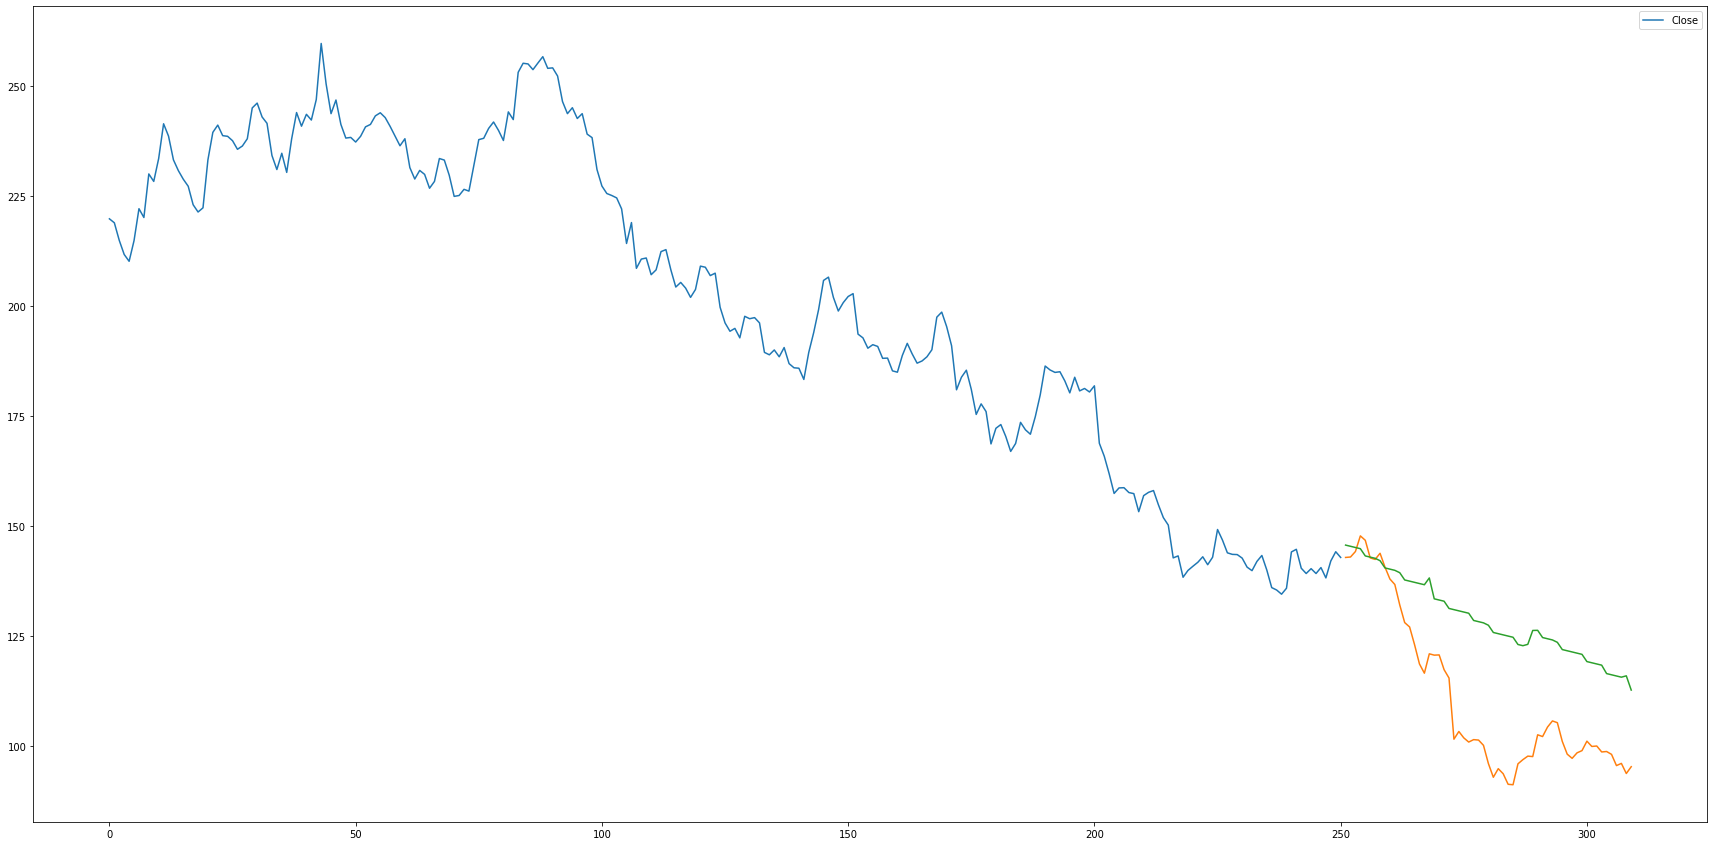

In [31]:
tata_model_plt = tata_train_X_plot.plot(y=['Close'], figsize=(30,15))
tata_model_plt.plot(predictions_df['test_data'])
tata_model_plt.plot(predictions_df['predictions'])

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results into a file

In [32]:
tata_predictions_data = {'Date': orders_df['Date'], 'Actual_Close': orders_df['TATAMTRDVR_Close']}
tata_predictions_df = pd.DataFrame(tata_predictions_data)
tata_predictions_df.head()

,Date,Actual_Close
0,2019-05-17,83.199997
1,2019-05-20,88.849998
2,2019-05-21,83.150002
3,2019-05-22,85.400002
4,2019-05-23,84.849998


In [33]:
predictions_df = predictions_df.reset_index()
tata_predictions_df['Linear_regression_Close'] = predictions_df['predictions']
tata_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2019-05-17,83.199997,145.655884
1,2019-05-20,88.849998,145.384391
2,2019-05-21,83.150002,145.112899
3,2019-05-22,85.400002,144.841406
4,2019-05-23,84.849998,143.197024


In [34]:
tata_predictions_df.to_csv('Tata_predicitions.csv', index=False)